In [1]:
import scanpy as sc 
import pandas as pd
import SEACells
import numpy as np
import matplotlib
from statistics import mode
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
sys.path.insert(0, '../')
import utils
from importlib import reload
reload(utils)
from utils import *
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

data_path = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Data/"
save_path_results = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Results/"

2024-07-12 19:47:52.160632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-12 19:47:55.954063: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [11]:
adata = sc.read(data_path+'Kang.h5ad')
adata

AnnData object with n_obs × n_vars = 24249 × 5000
    obs: 'tsne1', 'tsne2', 'replicate', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cov_cond'
    var: 'ensemble_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_colors', 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [12]:
ctrl_data = adata[adata.obs.condition == 'control'].copy()
ctrl_data

AnnData object with n_obs × n_vars = 12388 × 5000
    obs: 'tsne1', 'tsne2', 'replicate', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cov_cond'
    var: 'ensemble_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_colors', 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


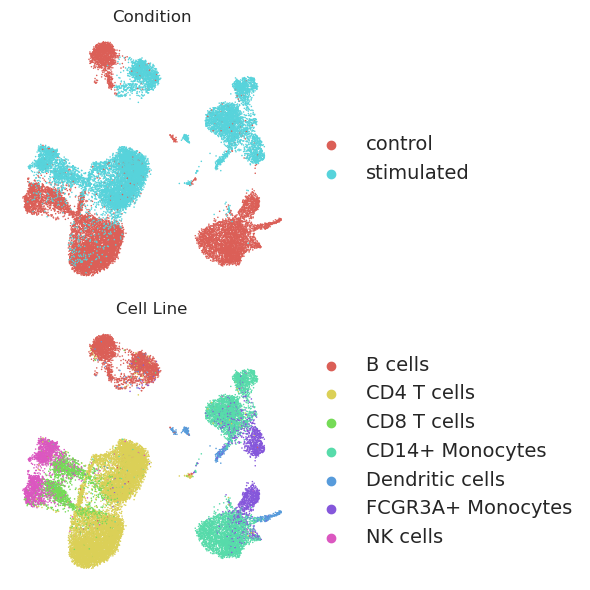

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(6, 6))  # Adjust figsize as needed
# Plot UMAP 1 in the first subplot if it's not empty
sc.pl.umap(adata=adata, color=["condition"],legend_fontsize=14,ax = axes[0],
           title = "Condition",
           show=False, palette = sns.color_palette("hls", 2),
           frameon=False)

sc.pl.umap(adata=adata, color=["cell_type"],legend_fontsize=14,ax = axes[1],
           title = "Cell Line",
           show=False, palette = sns.color_palette("hls", len(ctrl_data.obs.cell_type.unique())),
           frameon=False)

# Adjust spacing between subplots
plt.tight_layout()

# Show the merged plot
plt.show()

In [14]:
ctrl_data.obs.cell_type.value_counts()

cell_type
CD4 T cells          5242
CD14+ Monocytes      2828
B cells              1329
CD8 T cells          1096
NK cells              933
FCGR3A+ Monocytes     753
Dendritic cells       207
Name: count, dtype: int64

In [15]:
n_SEACells  = int(len(ctrl_data) / 50)
print(n_SEACells)
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

247


In [16]:
model = SEACells.core.SEACells(ctrl_data, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [17]:
model.construct_kernel_matrix()
M = model.kernel_matrix


Computing kNN graph using scanpy NN ...


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturb

Computing radius for adaptive bandwidth kernel...


  0%|          | 0/12388 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/12388 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/12388 [00:00<?, ?it/s]

Constructing CSR matrix...


In [18]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 223 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 34/34 [00:00<00:00, 44.61it/s]


Selecting 24 cells from greedy initialization.


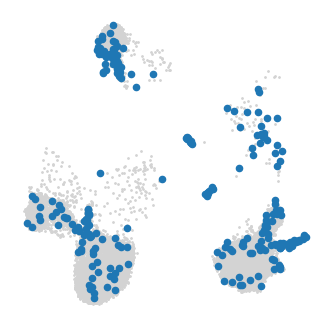

In [19]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ctrl_data, model)

In [20]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00201
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 46 iterations.


In [21]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 47 iterations
Ran for 52 iterations


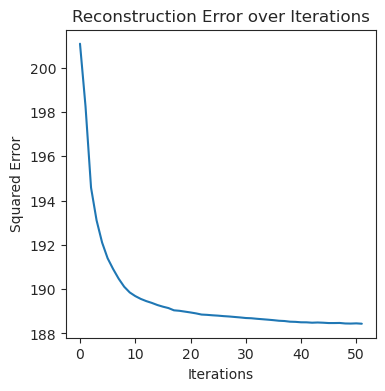

In [22]:
# Check for convergence 
model.plot_convergence()

In [23]:
ctrl_data.obs[['SEACell']].head()
ctrl_data.obs.cell_type

index
AAACATACATTTCC-1        CD14+ Monocytes
AAACATACCAGAAA-1        CD14+ Monocytes
AAACATACCATGCA-1            CD4 T cells
AAACATACCTCGCT-1        CD14+ Monocytes
AAACATACCTGGTA-1        Dendritic cells
                            ...        
TTCTGATGTCTCGC-1-1          CD4 T cells
TTGGAGTGCTCGAA-1-1          CD4 T cells
TTTAGCTGCGAACT-1-1          CD4 T cells
TTTATCCTGCGAGA-1-1    FCGR3A+ Monocytes
TTTATCCTGGAAAT-1-1      CD14+ Monocytes
Name: cell_type, Length: 12388, dtype: category
Categories (7, object): ['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells']

In [24]:
adata.obs['SEACell'] = 'None'
adata.obs.loc[ctrl_data.obs.index.tolist(), 'SEACell'] = ctrl_data.obs['SEACell'].values

In [25]:
ctrl_data.layers['X'] = ctrl_data.X

In [26]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ctrl_data,  model.A_, 
                                                          celltype_label='cell_type', summarize_layer = 'counts', minimum_weight = 0.05)
SEACell_soft_ad.X.A

100%|██████████| 247/247 [01:12<00:00,  3.42it/s]


array([[0.        , 0.08839835, 0.05737456, ..., 0.00743717, 0.00228086,
        0.25017344],
       [0.        , 0.03650971, 0.00341238, ..., 0.        , 0.        ,
        0.21736967],
       [0.00125094, 0.09064901, 0.        , ..., 0.0056844 , 0.02396393,
        0.20535267],
       ...,
       [0.01163207, 0.08162538, 0.02231341, ..., 0.02337508, 0.        ,
        0.15355642],
       [0.        , 0.01231867, 0.12248794, ..., 0.        , 0.        ,
        0.01861425],
       [0.        , 0.08580076, 0.01466601, ..., 0.00888293, 0.00125254,
        0.13469247]])

In [27]:
SEACell_soft_ad.obs

,Pseudo-sizes,celltype,celltype_purity
0,67.315867,CD4 T cells,0.979918
1,44.326924,CD14+ Monocytes,0.986218
2,57.529746,CD4 T cells,0.986929
3,44.980681,B cells,0.993444
4,41.772547,FCGR3A+ Monocytes,0.981861
...,...,...,...
242,69.712989,CD14+ Monocytes,0.986131
243,39.008732,B cells,0.989865
244,72.096915,CD4 T cells,0.977232
245,40.494836,CD14+ Monocytes,0.739248


In [28]:
SEACell_soft_ad.obs
SEACell_soft_ad.obs.rename({"celltype": "cell_type"}, axis=1, inplace=True)

In [29]:
SEACell_soft_ad.obs.cell_type.value_counts()

cell_type
CD4 T cells          81
CD14+ Monocytes      60
B cells              43
FCGR3A+ Monocytes    19
CD8 T cells          17
Dendritic cells      15
NK cells             12
Name: count, dtype: int64

In [30]:
SEACell_soft_ad.write(data_path+'SEACell_soft_ad_Kang.h5ad')

In [31]:
adata.write(data_path+'Kang.h5ad')

In [2]:
SEACell_soft_ad = sc.read(data_path+'SEACell_soft_ad_Kang.h5ad')
SEACell_soft_ad

AnnData object with n_obs × n_vars = 247 × 5000
    obs: 'Pseudo-sizes', 'cell_type', 'celltype_purity'

In [3]:
import os
import networkx as nx
from torch_geometric.utils.convert import from_networkx
from sklearn.metrics import mean_squared_error
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip, HeteroData, Batch
from torch_geometric.utils import *
import torch
from torch import nn
cell_type_network = {}
# Leaf directory 
directory = "Kang"
# Parent Directories 
parent_dir = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in SEACell_soft_ad.obs.cell_type.unique():
    print(cell_type)
    cell = Correlation_matrix(SEACell_soft_ad, cell_type, 'cell_type',
                       hv_genes_cells = None, union_HVGs = True)
    threshold = np.percentile(np.abs(cell[0].values), 99.0)
    print("threshold:", threshold)
    g = create_coexpression_graph(SEACell_soft_ad, cell, cell_type, threshold, 'gene_name')
    if g.num_nodes >= max_nodes:
        max_nodes = g.num_nodes
    cell_type_network[cell_type] = g
    genes_pos.append(cell_type_network[cell_type].pos)
    cell_type_network[cell_type].pos = torch.tensor(cell_type_network[cell_type].pos)
    torch.save(cell_type_network[cell_type] , os.path.join(path,cell_type+'_coexpr_graph.pkl'))

cell_type_network    

/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/Kang
File exists!
CD4 T cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.5661234221654932
CD14+ Monocytes


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.561704670070143
B cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.6611659126268048
FCGR3A+ Monocytes


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.5832994027985717
CD8 T cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.7179748370105064
NK cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.7353207287125247
Dendritic cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.7096199284688267


{'CD4 T cells': Data(x=[3728, 81], edge_index=[2, 122722], edge_attr=[122722], pos=[3728]),
 'CD14+ Monocytes': Data(x=[3499, 60], edge_index=[2, 123085], edge_attr=[123085], pos=[3499]),
 'B cells': Data(x=[3291, 43], edge_index=[2, 123034], edge_attr=[123034], pos=[3291]),
 'FCGR3A+ Monocytes': Data(x=[3327, 19], edge_index=[2, 123337], edge_attr=[123337], pos=[3327]),
 'CD8 T cells': Data(x=[3924, 17], edge_index=[2, 123015], edge_attr=[123015], pos=[3924]),
 'NK cells': Data(x=[3794, 12], edge_index=[2, 123103], edge_attr=[123103], pos=[3794]),
 'Dendritic cells': Data(x=[3199, 15], edge_index=[2, 123396], edge_attr=[123396], pos=[3199])}

In [4]:
overlap_df = pd.DataFrame(index = cell_type_network.keys(), columns = cell_type_network.keys())
for key1 in cell_type_network.keys():
    for key2 in cell_type_network.keys():
        overlap_df.loc[key1, key2] = (len(np.intersect1d(cell_type_network[key1].pos, cell_type_network[key2].pos)))

# identify the furthest cell type
indices = np.argsort(overlap_df.values, axis=0)[-7, :]
print(indices)
testing_cell = overlap_df.columns[mode(indices)]
print(testing_cell)
overlap_df

[6 2 6 0 2 2 0]
B cells


,CD4 T cells,CD14+ Monocytes,B cells,FCGR3A+ Monocytes,CD8 T cells,NK cells,Dendritic cells
CD4 T cells,3728,2737,2548,2587,3018,2899,2489
CD14+ Monocytes,2737,3499,2677,2924,3191,3139,2815
B cells,2548,2677,3291,2626,2920,2859,2529
FCGR3A+ Monocytes,2587,2924,2626,3327,3168,3163,2942
CD8 T cells,3018,3191,2920,3168,3924,3605,3050
NK cells,2899,3139,2859,3163,3605,3794,3057
Dendritic cells,2489,2815,2529,2942,3050,3057,3199


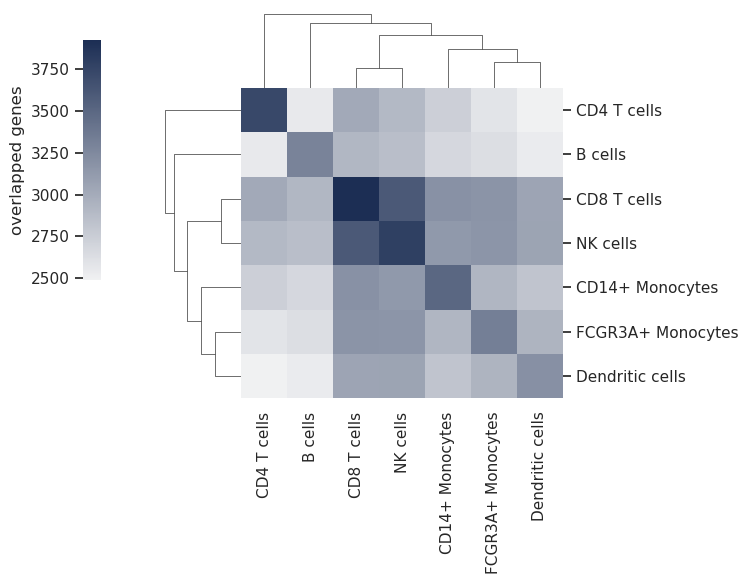

In [5]:
from matplotlib.colors import LinearSegmentedColormap
sns.set()
sns.set_style( {'axes.grid' : False})
import seaborn as sns
cmap = sns.light_palette("#1C2E54", as_cmap=True)
g = sns.clustermap(overlap_df.astype(int), figsize=(6, 6), cmap = cmap
                   , cbar_kws={'label': 'overlapped genes', 'location': 'left'})
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((-0.1, .52, .03, .4))
plt.savefig(save_path_results+'overlap_matrix_Kang.pdf', bbox_inches='tight')
plt.show()
sns.set()